In [25]:
%load_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import allison
from allison.nn import NeuralNetwork,Linear, CrossEntropyLoss,Tensor,no_grad,Relu,SGDMomentum
from allison.datasets import train_test_split,DataLoader,Dataset
from allison.metrics import confusion_matrix,classification_report

In [2]:
device = "gpu" if allison.is_cuda_available() else "cpu"
device

Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


'gpu'

In [3]:
data = pd.read_csv("../data/digit-recognizer/train.csv")

In [41]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data_train,data_test = train_test_split(data,test_size=0.2)

In [5]:
X_train = data_train.drop("label",axis=1).values
Y_train = data_train["label"].values

X_test = data_test.drop("label",axis=1).values
Y_test = data_test["label"].values

train_dataset = Dataset(X_train,Y_train)    
test_dataset = Dataset(X_test,Y_test)

train_dataloader = DataLoader(train_dataset,batch_size=64)
test_dataloader = DataLoader(test_dataset,batch_size=64)

In [6]:
for x,y in train_dataloader:
    print(x.shape,y.shape)
    break

(64, 784) (64,)


In [36]:
class Model(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(784,128)
        self.linear2 = Linear(128,64)
        self.linear3 = Linear(64,10)
        self.relu = Relu()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x
    

model = Model()
model.to(device)
loss_fn = CrossEntropyLoss()

optimizer = SGDMomentum(model.parameters(), learning_rate=1e-3, momentum=0.9)


In [37]:
epochs = 100

for epoch in range(epochs+1):
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in train_dataloader:
        x = Tensor(x, device=device)
        y = Tensor(y, device=device)

        # Forward
        y_pred = model(x)
        loss = loss_fn(y, y_pred)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular loss y accuracy
        total_train_loss += loss.data.get() * len(y)  # ponderar por tamaño del batch
        correct_train += (y_pred.data.argmax(axis=1) == y.data).sum().get()
        total_train += len(y)

    avg_train_loss = total_train_loss / total_train
    avg_train_acc = correct_train / total_train

    # --- Validación/Test ---
    if epoch % 10 == 0:
        with no_grad():
            total_test_loss = 0.0
            correct_test = 0
            total_test = 0

            for x, y in test_dataloader:
                x = Tensor(x, device=device)
                y = Tensor(y, device=device)

                y_pred = model(x)
                loss = loss_fn(y, y_pred)

                total_test_loss += loss.data.get() * len(y)
                correct_test += (y_pred.data.argmax(axis=1) == y.data).sum().get()
                total_test += len(y)

            avg_test_loss = total_test_loss / total_test
            avg_test_acc = correct_test / total_test
            
            print(f"[{epoch:3d}/{epochs:3d}] | Loss: {avg_test_loss:.4f} | Acc Train: {100*avg_train_acc:.2f}% | Acc Test: {100*avg_test_acc:.2f}%")


[  0/100] | Loss: 2.1168 | Acc Train: 16.72% | Acc Test: 18.15%
[ 10/100] | Loss: 1.9877 | Acc Train: 21.27% | Acc Test: 20.75%
[ 20/100] | Loss: 1.9923 | Acc Train: 21.43% | Acc Test: 21.00%
[ 30/100] | Loss: 1.3000 | Acc Train: 48.57% | Acc Test: 48.55%
[ 40/100] | Loss: 0.3159 | Acc Train: 92.90% | Acc Test: 91.99%
[ 50/100] | Loss: 0.2886 | Acc Train: 96.84% | Acc Test: 94.26%
[ 60/100] | Loss: 0.3138 | Acc Train: 97.68% | Acc Test: 94.90%
[ 70/100] | Loss: 0.3261 | Acc Train: 98.21% | Acc Test: 95.33%
[ 80/100] | Loss: 0.3427 | Acc Train: 98.18% | Acc Test: 95.29%
[ 90/100] | Loss: 0.3750 | Acc Train: 98.72% | Acc Test: 95.32%
[100/100] | Loss: 0.3873 | Acc Train: 99.21% | Acc Test: 95.74%


In [38]:
all_preds = []
all_targets = []

with no_grad():
    for x, y in test_dataloader:
        x = Tensor(x, device=device)
        y = Tensor(y, device=device)

        # Predicciones
        y_pred = model(x)
        preds = y_pred.data.argmax(axis=1).get()

        # Guardar predicciones y targets
        all_preds.extend(preds.tolist())
        all_targets.extend(y.data.get().tolist())


In [39]:
print(classification_report(all_targets,all_preds))

            precision   recall f1-score  support
0                0.97     0.97     0.97      798
1                0.98     0.98     0.98      920
2                0.96     0.97     0.96      797
3                0.95     0.96     0.95      858
4                0.95     0.96     0.96      813
5                0.94     0.95     0.95      772
6                0.97     0.97     0.97      849
7                0.97     0.95     0.96      929
8                0.94     0.93     0.94      810
9                0.93     0.93     0.93      854

accuracy                           0.00     8400
macro avg        0.96     0.96     0.96     8400
weighted avg     0.96     0.96     0.96     8400


<Axes: >

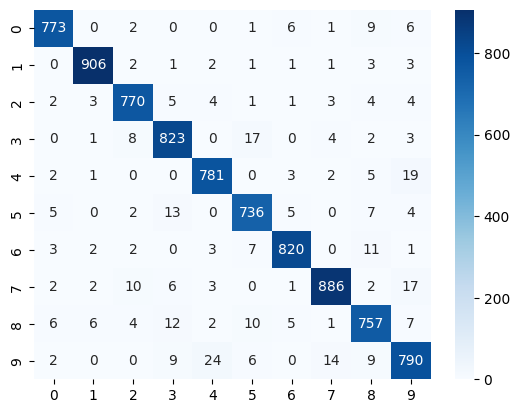

In [40]:
sns.heatmap(confusion_matrix(all_targets,all_preds), annot=True, cmap="Blues", fmt=".0f")